In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.layers import add,concatenate,Multiply,Conv2D,BatchNormalization,Reshape,Input
from keras.layers import Flatten,Dense,Dropout,LeakyReLU,UpSampling2D,ZeroPadding2D,Lambda
from keras.preprocessing import image
from keras.callbacks import *
from tensorflow.keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.layers import ELU, PReLU, LeakyReLU
#from keras.optimizers import SGD, Adam
import warnings
warnings.filterwarnings("ignore")

C:\Users\admin\AppData\Local\Temp\ipykernel_31256\4224099877.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from time import time
s = time()

DATADIR = "C:/Users/admin/Desktop/X_Rays_Dataset"
CATEGORIES = ["COVID","NORMAL"]
IMG_SIZE = 128
num_epoch =100

In [3]:
import tensorflow as tf

def loss_fn(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.45 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))


os.chdir(DATADIR)
training_data = []
training_data1 = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)

        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
                training_data1.append(new_array)

            except Exception as e:
                pass
    X = []
    y = []
    for features,label in training_data:
        X.append(features)
        y.append(label)
    #print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    img_rows = IMG_SIZE
    img_cols = IMG_SIZE
    channels = 3
    img_shape = [img_rows, img_cols, channels]
    return X,img_shape


dataset, shape = create_training_data()
print('Dataset shape: {0}, Image shape: {1}'.format(dataset.shape, shape))
print(len(training_data1))

100%|███████████████████████████████████████████████████████████████████████████| 10192/10192 [00:35<00:00, 290.17it/s]


Dataset shape: (13808, 128, 128, 3), Image shape: [128, 128, 3]
13808


In [4]:
import random#for randomizing our data
random.shuffle(training_data)
X=[]
y=[]
for features,label in training_data:
    X.append(features)
    y.append(label)
#print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 3))
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(to_categorical(y))

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.1)

In [5]:
#DEFINING New SQUASH function @Madhu
def squash(s, axis=-1):
    # Compute the squared norm using TensorFlow (sum of squares of the elements)
    squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
    # Use TensorFlow to compute the norm (instead of np.linalg.norm)
    norm_s = tf.sqrt(squared_norm)
    # Calculate the squash factor
    squash_factor = norm_s / (1. + squared_norm)
    # The unit vector is 's'. Make sure to keep the dimensions for broadcasting.
    unit_vector = s
    # Return the squashed output, ensuring squash_factor's shape is broadcastable.
    return squash_factor * unit_vector

In [6]:
from keras.regularizers import l2
def Encoder():
    Input_Layer = Input(shape=(IMG_SIZE,IMG_SIZE,3))
    Layer_1 = Conv2D(128, kernel_initializer='lecun_normal', kernel_size = (3,3),strides=2, padding ='valid',activation ='relu')(Input_Layer)
    Layer_N1 = BatchNormalization()(Layer_1)
    Layer_N1 = Dropout(0.25)(Layer_N1)
    Layer_2 = Conv2D(128, kernel_initializer='lecun_normal', kernel_size = (3,3),strides=2, padding ='valid',activation ='relu')(Layer_N1)
    Layer_N2 = BatchNormalization()(Layer_2)
    Layer_3 = Conv2D(64, kernel_initializer='lecun_normal', kernel_size = (3,3),strides=2, padding ='valid', activation ='relu')(Layer_N2)
    Layer_N3 = BatchNormalization()(Layer_3)
    Layer_4= Conv2D(64, kernel_initializer='lecun_normal', kernel_size = (3,3),strides=2, padding ='valid',activation ='relu')(Layer_N3)
    Layer_N4 = BatchNormalization()(Layer_4)
    Layer_5= Conv2D(128, kernel_initializer='lecun_normal', kernel_size = (3,3),strides=2, padding ='valid',activation ='relu')(Layer_N4)
    Layer_N5 = BatchNormalization()(Layer_5)
#    Layer_6= Conv2D(64, kernel_size = (3,3), padding ='valid',activation ='relu')(Layer_N5)
#    Layer_N6 = BatchNormalization()(Layer_6)
#    Layer_7= Conv2D(64, kernel_size = (3,3), padding ='valid',activation ='relu')(Layer_N6)
#    Layer_N7 = BatchNormalization()(Layer_7)
#    Layer_8= Conv2D(64, kernel_size = (3,3), padding ='valid',activation ='relu')(Layer_N7)
#    Layer_N8 = BatchNormalization()(Layer_8)
#    Layer_9= Conv2D(8 * 4, kernel_size = (3,3), padding ='valid',activation ='relu')(Layer_N8)
#    Layer_N9 = BatchNormalization()(Layer_9)
    Layer_R = Reshape([-1,2])(Layer_N3)
    # Layer_L = Lambda(squash)(Layer_R)
    Layer_L = Lambda(squash, output_shape=lambda input_shape: (input_shape[0], input_shape[1], 2))(Layer_R)
######################################  ROUTING MECHANISM #############################################################################
    x = BatchNormalization()(Layer_L)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    Pred_Vec = Dense(64, kernel_initializer='lecun_normal', bias_initializer='zeros',activation='relu', kernel_regularizer=l2(1e-3))(x)
    c = Activation('softmax', name='softmax_digitcaps1')(Pred_Vec)
    c= Dropout(0.5)(c)
    c = Dense(64, kernel_initializer='lecun_normal', bias_initializer='zeros')(c)
    x = Multiply()([Pred_Vec, c])
    s_j = PReLU()(x)
    #############Routing####################
    #1
    c = Activation('softmax', name='softmax_digitcaps2')(s_j)
    c = Dense(64, kernel_initializer='lecun_normal', bias_initializer='zeros')(c)
    x = Multiply()([Pred_Vec, c])
    s_j = PReLU()(x)

    #2

    # c = Activation('softmax', name='softmax_digitcaps3')(s_j)
    # c = Dense(64, kernel_initializer='lecun_normal', bias_initializer='zeros')(c)
    # x = Multiply()([Pred_Vec, c])
    # s_j = PReLU()(x)

    #3
    # c = Activation('softmax', name='softmax_digitcaps4')(s_j)
    # c = Dense(64, kernel_initializer='lecun_normal', bias_initializer='zeros')(c)
    # x = Multiply()([Pred_Vec, c])
    # s_j = PReLU()(x)
#######################################################################################################################################
    y = Dense(64, kernel_initializer='lecun_normal', bias_initializer='zeros')(s_j)
    y = Dropout(0.75)(y)
    y = Dense(512, kernel_initializer='lecun_normal', bias_initializer='zeros', kernel_regularizer=l2(1e-3))(y)
    y = Dense(1024, kernel_initializer='lecun_normal', bias_initializer='zeros')(y)
    y = Dropout(0.5)(y)
    #y = Dense(128)(y)

    Output_Layer = Dense(len(CATEGORIES), kernel_initializer='lecun_normal', bias_initializer='zeros', activation='softmax')(y)
    #return Model(Input_Layer, Layer_N7)
    return Model(Input_Layer, Output_Layer)

discriminator = Encoder()
print('DISCRIMINATOR:')
discriminator.summary()

DISCRIMINATOR:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                               

In [7]:
opt = keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.999, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
discriminator.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy']) # metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

model=discriminator
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

start_time = s

import tensorflow as tf
tf.keras.backend.clear_session()

import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

44/44 [==============================] - 8s 16ms/step - loss: 0.8110 - accuracy: 0.7234
Test loss: 0.8110366463661194
Test accuracy: 0.7233888506889343
Keras version: 2.10.0
TensorFlow version: 2.10.1


In [8]:
history=model.fit(x_train,y_train,batch_size=16,epochs=num_epoch
                  ,shuffle=True,validation_data=(x_test,y_test))
training_time = s-start_time
y_pred=model.predict(x_test,batch_size=16)

start_time = s
#Model loss and accuracy
loss,acc = model.evaluate(x_test,  y_test, verbose=2)
testing_time = s-start_time
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/100
777/777 [==============================] - 22s 24ms/step - loss: 0.7125 - accuracy: 0.7369 - val_loss: 0.6746 - val_accuracy: 0.7234
Epoch 2/100
777/777 [==============================] - 18s 23ms/step - loss: 0.6321 - accuracy: 0.7708 - val_loss: 0.6005 - val_accuracy: 0.8103
Epoch 3/100
777/777 [==============================] - 18s 23ms/step - loss: 0.5656 - accuracy: 0.8307 - val_loss: 0.5281 - val_accuracy: 0.8559
Epoch 4/100
777/777 [==============================] - 18s 23ms/step - loss: 0.5094 - accuracy: 0.8553 - val_loss: 0.4745 - val_accuracy: 0.8878
Epoch 5/100
777/777 [==============================] - 18s 23ms/step - loss: 0.4635 - accuracy: 0.8782 - val_loss: 0.4290 - val_accuracy: 0.9044
Epoch 6/100
777/777 [==============================] - 18s 23ms/step - loss: 0.4223 - accuracy: 0.8937 - val_loss: 0.3934 - val_accuracy: 0.9203
Epoch 7/100
777/777 [==============================] - 18s 23ms/step - loss: 0.3867 - accuracy: 0.9067 - val_loss: 0.3621 - val_ac

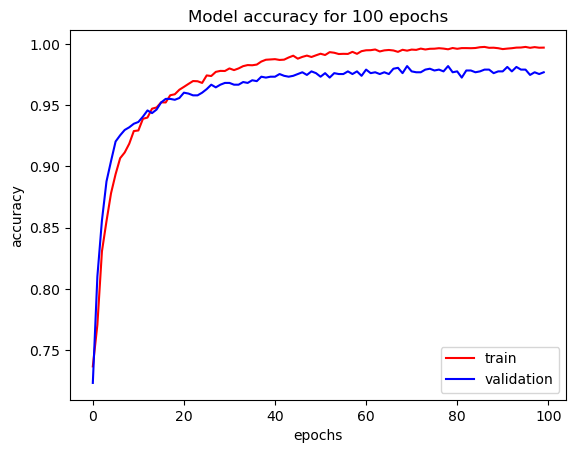

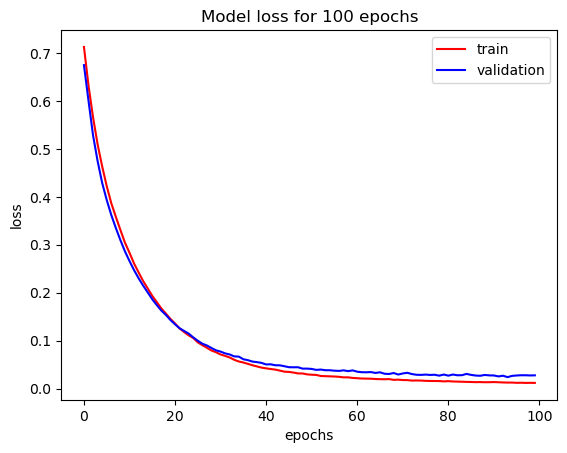

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='b')
plt.title('Model accuracy for {0} epochs'.format(num_epoch))
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='b')
plt.title('Model loss for {0} epochs'.format(num_epoch))
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [10]:
print("Accuracy :",np.mean(history.history['accuracy']),np.std(history.history['accuracy']))
print("Validation Accuracy :",np.mean(history.history['val_accuracy']),np.std(history.history['val_accuracy']))
#evaluating our model on test_data
y_pred=np.round(np.squeeze(model.predict(x_test)))
y_true=np.argmax(np.array(y_test),axis=-1)
pred=np.argmax(y_pred,axis=-1)


from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
cm=confusion_matrix(y_true,pred)
cr=classification_report(y_true, pred)
ac=accuracy_score(y_true, pred)
# import scikitplot as skplt
# skplt.metrics.plot_roc_curve(y_true, y_pred)
#skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=True)
#skplt.metrics.plot_precision_recall_curve(y_test, y_pred[:,])
plt.show()
print("Confusion Matrix:\n\n",cm,"\n"*3)
print("Classification report:\n\n",cr,"\n"*3)
print("Testing Accuracy : ",ac)
print("Seconds since epoch =", time()-s)
print(f"Training_time: {training_time} seconds")
print(f"Testing_time: {testing_time} seconds")

Accuracy : 0.9731946575641632 0.04412538723344784
Validation Accuracy : 0.9624764651060105 0.03499936514160414
44/44 [==============================] - 1s 11ms/step
Confusion Matrix:

 [[365  17]
 [ 15 984]] 



Classification report:

               precision    recall  f1-score   support

           0       0.96      0.96      0.96       382
           1       0.98      0.98      0.98       999

    accuracy                           0.98      1381
   macro avg       0.97      0.97      0.97      1381
weighted avg       0.98      0.98      0.98      1381
 



Testing Accuracy :  0.9768283852280956
Seconds since epoch = 1900.74760389328
Training_time: 0.0 seconds
Testing_time: 0.0 seconds
